# Swing Decision Model

Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim

Load the Data (Frontier League pitch-by-pitch data 2025)

In [2]:
df = pd.read_csv('fl_data_25.csv')
df.head()

C:\Users\nikhi\AppData\Local\Temp\ipykernel_29448\2352056760.py:1: DtypeWarning: Columns (28,41,169,170,171,172,173,174,175,176,177) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('fl_data_25.csv')


,Unnamed: 0,PitchNo,Date,Time,PAofInning,PitchofPA,Pitcher,PitcherId,PitcherThrows,PitcherTeam,...,Swing,Chase,FieldSide,PitchSource,PitchClass,xDamage,xwOBA,xSLG,xBA,barrel
0,1,1,2025-05-16,19:10:08.62,1.0,1.0,"Sittinger, Brandyn",670087.0,Right,Lake Erie Crushers,...,False,False,NaN,Fastball,Fastball,NaN,NaN,NaN,NaN,NaN
1,2,2,2025-05-16,19:10:20.59,1.0,2.0,"Sittinger, Brandyn",670087.0,Right,Lake Erie Crushers,...,True,False,Right,Fastball,Fastball,7.542667e-01,7.542667e-01,8.010000e-01,7.851667e-01,0.0
2,3,3,2025-05-16,19:10:55.20,2.0,1.0,"Sittinger, Brandyn",670087.0,Right,Lake Erie Crushers,...,True,True,Right,Fastball,Fastball,NaN,NaN,NaN,NaN,NaN
3,4,4,2025-05-16,19:11:17.11,2.0,2.0,"Sittinger, Brandyn",670087.0,Right,Lake Erie Crushers,...,True,False,Middle,Fastball,Fastball,NaN,NaN,NaN,NaN,NaN
4,5,5,2025-05-16,19:11:42.09,2.0,3.0,"Sittinger, Brandyn",670087.0,Right,Lake Erie Crushers,...,True,False,Middle,Fastball,Fastball,-1.887379e-16,-1.887379e-16,-3.963496e-16,-5.601075e-16,0.0


Clean Data (Drop NAs, define Swing/Miss)

In [3]:
# Define swing (1) vs take (0)
df['swing'] = df['PitchCall'].isin([
    'StrikeSwinging', 'FoulBallNotFieldable', 'InPlay'
]).astype(int)

# Drop rows with missing critical features
df = df.dropna(subset=[
    'RelSpeed', 'PlateLocSide', 'PlateLocHeight', 'Balls', 'Strikes', 'VertBreak', 'HorzBreak',
    'PitcherThrows', 'BatterSide', 'PitchClass', 'Extension', 'HangTime'
])

Feature Selection

In [4]:
num_features = [
    'RelSpeed', 'VertBreak', 'HorzBreak',
    'PlateLocSide', 'PlateLocHeight',
    'Balls', 'Strikes', 'Extension', 'HangTime'
]

cat_features = ['PitcherThrows', 'BatterSide', 'PitchClass']

X = df[num_features + cat_features]
y = df['swing']

Preprocessing (Scaling + One-Hot Encoding)

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
])

X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

Convert to PyTorch Tensors

In [6]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=128, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=128)

Define the Neural Network

In [7]:
class SwingDecisionNN(nn.Module):
    def __init__(self, input_dim):
        super(SwingDecisionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

model = SwingDecisionNN(X_train_tensor.shape[1])
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

Train the Model

In [8]:
num_epochs = 15

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # Remove NaNs from outputs and y_batch
        mask = (~torch.isnan(outputs)) & (~torch.isnan(y_batch))
        outputs_clean = outputs[mask]
        y_batch_clean = y_batch[mask]
        if outputs_clean.numel() == 0:
            continue  # skip this batch if all values are NaN
        # Clamp outputs to [0, 1] to avoid BCELoss errors
        loss = criterion(outputs_clean.clamp(0, 1), y_batch_clean.clamp(0, 1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/15], Loss: 0.1094
Epoch [2/15], Loss: 0.0740
Epoch [3/15], Loss: 0.0712
Epoch [4/15], Loss: 0.0688
Epoch [5/15], Loss: 0.0662
Epoch [6/15], Loss: 0.0651
Epoch [7/15], Loss: 0.0654
Epoch [8/15], Loss: 0.0646
Epoch [9/15], Loss: 0.0627
Epoch [10/15], Loss: 0.0637
Epoch [11/15], Loss: 0.0634
Epoch [12/15], Loss: 0.0629
Epoch [13/15], Loss: 0.0628
Epoch [14/15], Loss: 0.0627
Epoch [15/15], Loss: 0.0620


Get Model Results

Any NaNs in model output? False


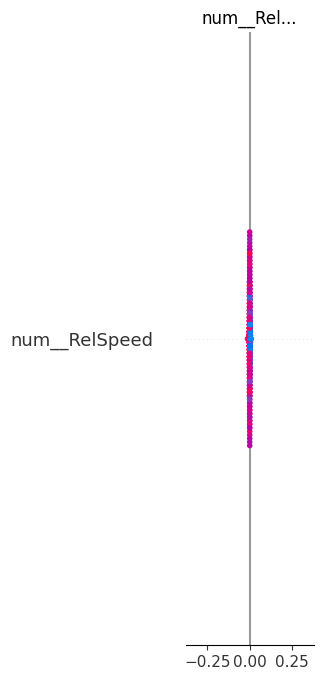

In [29]:
import shap

# Check model outputs for NaNs before running SHAP
with torch.no_grad():
	outputs_check = model(X_test_tensor[:500])
	print("Any NaNs in model output?", torch.isnan(outputs_check).any().item())

# If no NaNs, run SHAP
if not torch.isnan(outputs_check).any():
	explainer = shap.DeepExplainer(model, X_train_tensor[:500])
	shap_values = explainer.shap_values(X_test_tensor[:500])
	shap.summary_plot(shap_values, features=X_test_tensor[:500].detach().cpu().numpy(), feature_names=preprocessor.get_feature_names_out())
else:
	print("Model outputs contain NaNs. Please check your model and input data.")

In [79]:
preprocessor.get_feature_names_out()

array(['num__RelSpeed', 'num__VertBreak', 'num__HorzBreak',
       'num__PlateLocSide', 'num__PlateLocHeight', 'num__Balls',
       'num__Strikes', 'num__Extension', 'cat__PitcherThrows_Both',
       'cat__PitcherThrows_Left', 'cat__PitcherThrows_Right',
       'cat__PitcherThrows_Undefined', 'cat__BatterSide_L',
       'cat__BatterSide_Left', 'cat__BatterSide_Right',
       'cat__BatterSide_Undefined', 'cat__PitchClass_Breaking',
       'cat__PitchClass_Fastball', 'cat__PitchClass_Offspeed',
       'cat__PitchClass_Other'], dtype=object)